# Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import random
 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from scipy import stats

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.


In [2]:
import warnings
warnings.filterwarnings('ignore')

# Вспомогательные функции

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def analize(data, index):
    plt.figure(figsize=(8, 2))
    sns.boxplot(data[index])
    plt.xlabel(index)
    plt.show()

    print(f'\nКоличество пропущенных элементов {data[index].isnull().sum()}')
    print(f'median - {round(np.quantile(data[index], q=0.5), 2)}\nmean - {round(np.mean(data[index]), 2)}\nmode - {round(stats.mode(data[index])[0][0], 2)}\n')
    print(data[index].value_counts().sort_index(ascending=True))
    print(f'\nКоличество уникальных элементов {data[index].value_counts().size}')

In [5]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

# Загрузка данных

## Обучающая выборка

In [6]:
train_df = pd.read_csv('train.csv.zip')
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [7]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

## Контрольная выборка

In [8]:
test_df = pd.read_csv('test.csv')
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,10379,29,2.0,43.177521,30.339945,5.0,6,5.0,1962,0.069660,B,B,31,6119,4,NaN,1,2,B
4996,16138,38,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,B,B,15,2787,2,520.0,0,7,B
4997,3912,101,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,B,B,28,6533,1,1015.0,2,5,B
4998,5722,10,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,B,B,33,7976,5,NaN,0,11,B
4999,11004,21,2.0,67.122742,33.944344,13.0,9,17.0,2009,0.194489,B,B,47,8004,3,125.0,3,5,B


In [9]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте 5000


In [10]:
train_df.shape[1] - 1 == test_df.shape[1]

True

# Приведение типов

In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [12]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(int)

# EDA

## Целевая переменная

In [13]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
# target_mode = train_df['Price'].mode()[0] - если посмотреть на 
# train_df['Price'].value_counts() - то в ценах все уникальные числа, поэтому это не информативный параметр

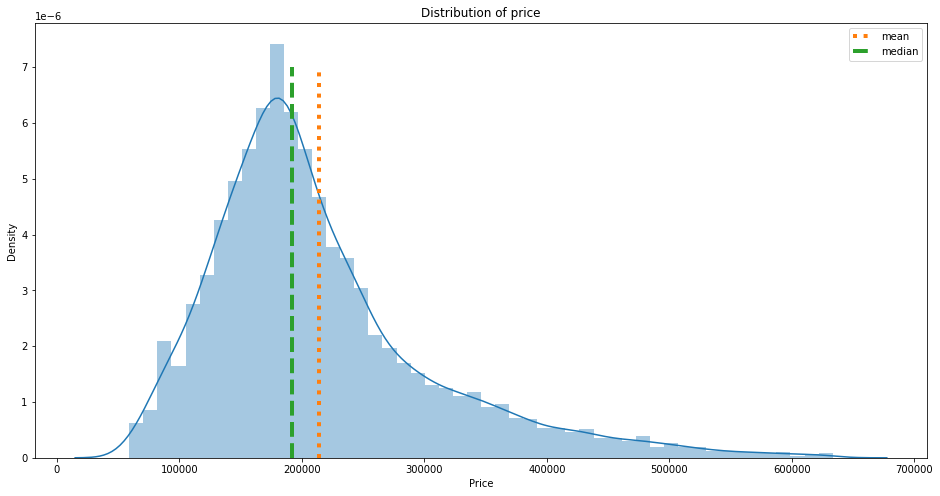

In [14]:
plt.figure(figsize = (16, 8))

sns.distplot(train_df['Price'], bins=50)

y = np.linspace(0, 0.000007, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
# plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of price')
plt.legend()
plt.show()

## Количественные переменные

In [15]:
train_df.describe()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [16]:
df_num_features = train_df.select_dtypes(include=['float64', 'int64'])
df_num_features.drop('Price', axis=1, inplace=True)

In [17]:
df_num_features.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6


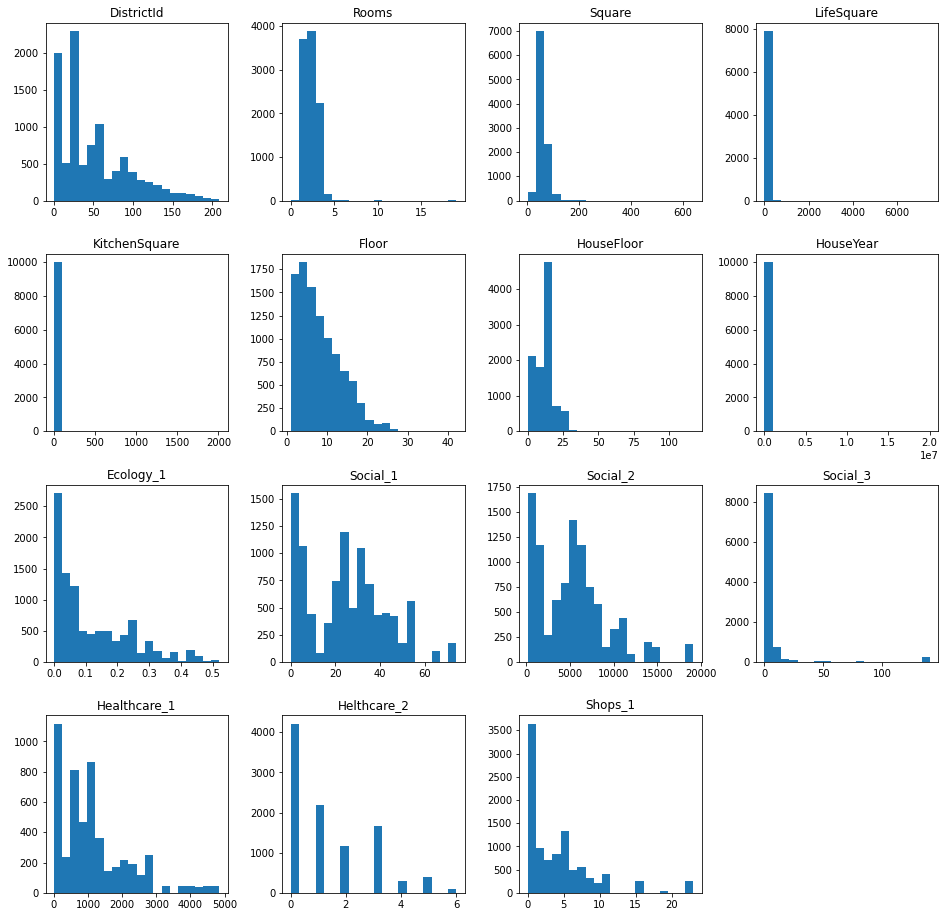

In [18]:
df_num_features.hist(figsize=(16, 16), bins=20, grid=False);

## Номинальные переменные

In [19]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [20]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
196      1
117      1
205      1
199      1
207      1
Name: DistrictId, Length: 205, dtype: int64

In [21]:
train_df['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [22]:
train_df['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [23]:
train_df['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

<div class="girk">
    Выглядит так, что эти признаки Ecology_2, Ecology_3, Shops_2 - только шум добавят в данные, так как В - больше 90%
    Возможны несколько вариантов:
    1) удалить эти фичи, так как по количеству кажется что они не информативны
    но не понятно что они тут имеют ввиду под этими фичами, а вдруг что-то важное?
    2) можно предположить что это важные фичи и сделать стратифицированные выборки на обучающей и валидационной выборке
    разделяться данные как-то и их анализировать
    3) можно ничего не делать и так и оставить
    
    У меня был принцип все удалять, но так я больше запуталась во всем и в итоге остановилась на том, чтобы все оставить
</div><i class="fa fa-lightbulb-o "></i>

# Обработка выбросов

## Rooms

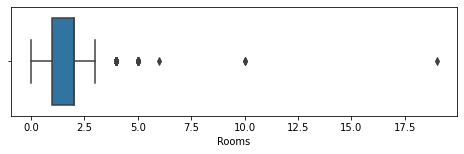


Количество пропущенных элементов 0
median - 2.0
mean - 1.89
mode - 2.0

0.0        8
1.0     3705
2.0     3880
3.0     2235
4.0      150
5.0       18
6.0        1
10.0       2
19.0       1
Name: Rooms, dtype: int64

Количество уникальных элементов 9


In [24]:
analize(train_df, 'Rooms')

In [25]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.102962,0


In [26]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

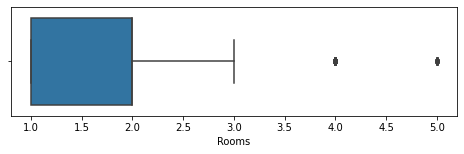


Количество пропущенных элементов 0
median - 2.0
mean - 1.89
mode - 2.0

1.0    3713
2.0    3884
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

Количество уникальных элементов 5


In [27]:
analize(train_df, 'Rooms')

<div class="girk">
    Анализирую важность фич, то Rooms и следующие фичи Square, жил площадь и кухня оч сильно оказывают влияние на построение моделей, поэтому важно выбросы в них обработать, но что истинно в этх данных? Допустим
    Мы точно знаем, что общая площадь не может быть меньше кухни или жил площади или их суммы
    Мы точно знаем что 5 комнатная квартира ну не может быть с жил площадью чуть больше 10
    Или то что 1 комнатная будет больше 150 кв м? Хотя если это гиганская студия?
    
    Если учесть легко условие - общая площадь не может быть меньше кухни или жил площади или их суммы
    То уже с количеством комнат и площадьми сложно, Потому что не понятно на что менять? Медианны или средние - не обоснованно, да и еще оно же зависит от цены! и возможно района! У меня не хватило ума обработать эту ситуацию, но явные косяки тут есть
</div><i class="fa fa-lightbulb-o "></i>

## Square

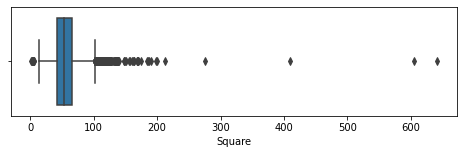


Количество пропущенных элементов 0
median - 52.51
mean - 56.32
mode - 1.14

1.136859      1
1.988943      1
2.377248      1
2.596351      1
2.954309      1
             ..
212.932361    1
275.645284    1
409.425181    1
604.705972    1
641.065193    1
Name: Square, Length: 10000, dtype: int64

Количество уникальных элементов 10000


In [28]:
#Square - площадь
analize(train_df, 'Square')

<div class="girk">
    Средним я не хочу заполнять, мне кажется надо взять средние значения площади в зависимости от комнаты
</div><i class="fa fa-lightbulb-o "></i>

In [29]:
mean_square_rooms = train_df[(train_df['Square'] < 150)&(train_df['Square'] >= 10)].\
groupby(['Rooms'], as_index=False).agg({'Square':'median'}).rename(columns={'Square':'MeanSquare'})

In [30]:
mean_square_rooms

,Rooms,MeanSquare
0,1.0,40.417909
1,2.0,55.841812
2,3.0,77.367147
3,4.0,98.212308
4,5.0,112.135525


In [31]:
train_df = train_df.merge(mean_square_rooms, on=['Rooms'], how='left', )

<div class="girk">
    одно двухкомнатные квартиры с площадью 100 кв м странно, возможно ошиблись с количеством комнат или площадью

</div><i class="fa fa-lightbulb-o "></i>

In [32]:
conditions = ((train_df['Square'] > 100) & (train_df['Rooms'] <= 2))

In [33]:
train_df['Square_outlires'] = 0
train_df.loc[conditions, 'Square_outlires'] = 1

In [34]:
train_df.loc[conditions, 'Square'] = train_df[train_df.Square_outlires == 1].MeanSquare

<div class="girk">
    обрабатываем ситуацию когда площадь меньше 10 или больше 150
</div><i class="fa fa-lightbulb-o "></i>

In [35]:
train_df.loc[train_df[train_df['Square'] < 10].index, 'Square'] = \
train_df.loc[train_df[train_df['Square'] < 10].index, 'MeanSquare']

In [36]:
train_df.loc[train_df[train_df['Square'] >= 150].index, 'Square'] = \
train_df.loc[train_df[train_df['Square'] >= 150].index, 'MeanSquare']

In [37]:
train_df.loc[train_df[train_df['Square'] < 10].index, 'Square_outlires'] = 1
train_df.loc[train_df[train_df['Square'] >= 150].index, 'Square_outlires'] = 1

In [38]:
train_df.drop('MeanSquare', axis=1, inplace=True)

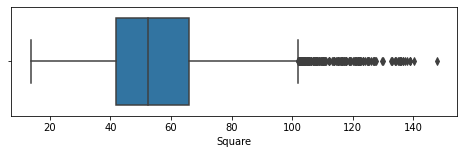


Количество пропущенных элементов 0
median - 52.4
mean - 55.79
mode - 40.42

13.784865     1
16.117154     1
16.547242     1
17.046188     1
17.414181     1
             ..
138.700092    1
138.980817    1
138.995003    1
140.242987    1
147.709302    1
Name: Square, Length: 9937, dtype: int64

Количество уникальных элементов 9937


In [39]:
#Square - площадь
analize(train_df, 'Square')

## KitchenSquare

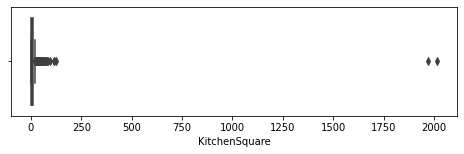


Количество пропущенных элементов 0
median - 6.0
mean - 6.27
mode - 1.0

0.0        697
1.0       2460
2.0          4
3.0         22
4.0         39
5.0       1169
6.0       1038
7.0        609
8.0       1306
9.0        843
10.0      1075
11.0       233
12.0       249
13.0        67
14.0        51
15.0        31
16.0        16
17.0        12
18.0         6
19.0        11
20.0        14
21.0         1
22.0         3
23.0         1
25.0         2
26.0         1
27.0         1
29.0         1
30.0         2
31.0         1
32.0         2
35.0         1
36.0         1
37.0         2
39.0         1
40.0         1
41.0         2
42.0         1
43.0         2
48.0         1
51.0         2
53.0         1
54.0         1
58.0         2
60.0         1
62.0         1
63.0         1
66.0         1
72.0         1
73.0         1
75.0         1
78.0         1
84.0         1
96.0         1
112.0        2
123.0        1
1970.0       1
2014.0       1
Name: KitchenSquare, dtype: int64

Количество уникальных 

In [40]:
analize(train_df, 'KitchenSquare')

<div class="girk">
    ну не. может быть кухня половины общей площади квартиры или меньше 3
</div><i class="fa fa-lightbulb-o "></i>

In [41]:
condition = ((train_df['KitchenSquare'] > (train_df['Square'] * 0.5)) | (train_df['KitchenSquare'] < 3))

In [42]:
train_df['KitchenSquare_outlires'] = 0
train_df.loc[conditions, 'KitchenSquare_outlires'] = 1

<div class="girk">
    А как исправить площадь кухни? Посмотрела на среднее отношение кухни к площади и на это число и умножала
</div><i class="fa fa-lightbulb-o "></i>

In [43]:
x = train_df.loc[~condition, 'KitchenSquare']/train_df.loc[~condition,'Square']

In [44]:
x.describe()

count    6804.000000
mean        0.154816
std         0.048344
min         0.027348
25%         0.118077
50%         0.148099
75%         0.182876
max         0.494830
dtype: float64

In [45]:
train_df.loc[condition, 'KitchenSquare'] = 0.15 * train_df.loc[condition, 'Square']

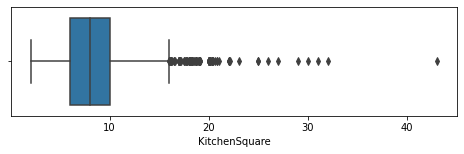


Количество пропущенных элементов 0
median - 8.0
mean - 8.29
mode - 8.0

2.067730     1
2.417573     1
2.612127     1
2.624781     1
2.847594     1
            ..
29.000000    1
30.000000    1
31.000000    1
32.000000    1
43.000000    1
Name: KitchenSquare, Length: 3187, dtype: int64

Количество уникальных элементов 3187


In [46]:
analize(train_df, 'KitchenSquare')

## LifeSquare

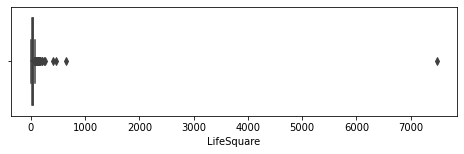


Количество пропущенных элементов 2113
median - nan
mean - 37.2
mode - 0.37

0.370619       1
0.641822       1
0.795539       1
0.873147       1
1.049867       1
              ..
263.542020     1
410.639749     1
461.463614     1
638.163193     1
7480.592129    1
Name: LifeSquare, Length: 7887, dtype: int64

Количество уникальных элементов 7887


In [47]:
analize(train_df, 'LifeSquare')

<div class="girk">
    Обработаем пропуски
</div><i class="fa fa-lightbulb-o "></i>

In [48]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                            - train_df.loc[condition, 'KitchenSquare'] - 3

<div class="girk">
    далее все аналогично обрабатываем
</div><i class="fa fa-lightbulb-o "></i>

In [49]:
train_df['LifeSquare_outlires'] = 0

In [50]:
condition = ((train_df['LifeSquare'] < 10) | (train_df['LifeSquare'] >= 150))
train_df.loc[conditions, 'LifeSquare_outlires'] = 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                        - train_df.loc[condition, 'KitchenSquare'] - 3

In [51]:
condition = train_df[train_df['KitchenSquare'] > train_df['LifeSquare']].index
train_df.loc[conditions, 'LifeSquare_outlires'] = 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                        - train_df.loc[condition, 'KitchenSquare']

In [52]:
condition = train_df[train_df['LifeSquare'] > train_df['Square']].index
train_df.loc[conditions, 'LifeSquare_outlires'] = 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                        - train_df.loc[condition, 'KitchenSquare'] - 3

In [53]:
condition = train_df[train_df['Square'] < train_df['KitchenSquare'] +  train_df['LifeSquare']].index
train_df.loc[conditions, 'LifeSquare_outlires'] = 1
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                        - train_df.loc[condition, 'KitchenSquare'] - 3

In [54]:
x = train_df.LifeSquare/train_df.Rooms

In [55]:
x.describe()

count    10000.000000
mean        21.468972
std          7.214216
min          1.849081
25%         15.985305
50%         20.053330
75%         24.778524
max         80.650749
dtype: float64

In [56]:
condition = train_df[x < 10].index
train_df.loc[condition, 'LifeSquare'] = train_df.loc[condition, 'Square'] \
                                        - train_df.loc[condition, 'KitchenSquare'] - 3

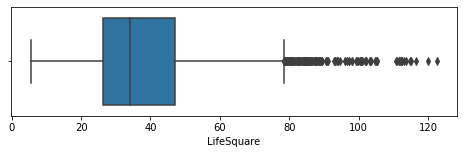


Количество пропущенных элементов 0
median - 33.98
mean - 37.77
mode - 31.36

5.547242      1
6.046188      1
8.717135      1
10.651455     1
10.699581     1
             ..
114.895078    1
115.145752    1
116.475017    1
119.907783    1
122.552907    1
Name: LifeSquare, Length: 9962, dtype: int64

Количество уникальных элементов 9962


In [57]:
analize(train_df, 'LifeSquare')

## HouseFloor, Floor

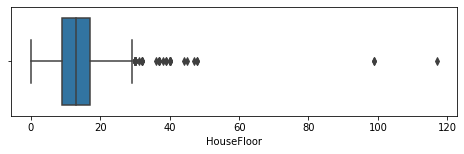


Количество пропущенных элементов 0
median - 13.0
mean - 12.61
mode - 17.0

0.0       269
1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0       27
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

Количество уникальных элементов 44


In [58]:
analize(train_df, 'HouseFloor')

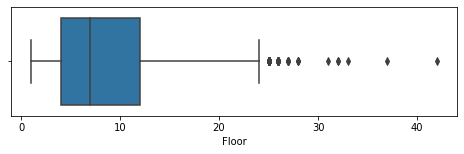


Количество пропущенных элементов 0
median - 7.0
mean - 8.53
mode - 4

1     235
2     588
3     872
4     949
5     876
6     802
7     759
8     643
9     604
10    553
11    457
12    438
13    398
14    362
15    287
16    290
17    256
18    185
19    121
20     68
21     59
22     54
23     25
24     53
25     34
26     18
27      5
28      3
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

Количество уникальных элементов 33


In [59]:
analize(train_df, 'Floor')

In [60]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [61]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42])

In [62]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [63]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1


In [64]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()


In [65]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

<div class="girk">
    я не смогла придумать что-то умное
</div><i class="fa fa-lightbulb-o "></i>

In [66]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [67]:
(train_df['Floor'] > train_df['HouseFloor']).sum()


0

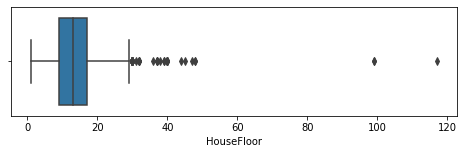


Количество пропущенных элементов 0
median - 13.0
mean - 12.96
mode - 17.0

1.0       497
2.0        48
3.0       127
4.0       134
5.0      1031
6.0        58
7.0        59
8.0       141
9.0      1389
10.0      135
11.0       28
12.0     1074
13.0      296
14.0      625
15.0      123
16.0      576
17.0     2331
18.0       89
19.0      108
20.0      105
21.0       33
22.0      343
23.0       40
24.0      176
25.0      374
26.0        1
27.0        6
28.0        3
29.0        1
30.0       21
31.0        1
32.0        4
36.0        1
37.0        4
38.0        1
39.0        2
40.0        7
44.0        1
45.0        1
47.0        1
48.0        2
99.0        2
117.0       1
Name: HouseFloor, dtype: int64

Количество уникальных элементов 43


In [68]:
analize(train_df, 'HouseFloor')

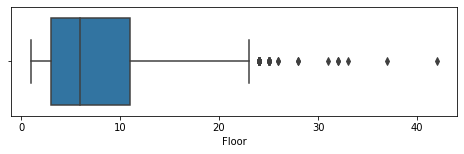


Количество пропущенных элементов 0
median - 6.0
mean - 7.39
mode - 3

1     876
2     753
3     961
4     959
5     899
6     650
7     684
8     674
9     606
10    427
11    397
12    426
13    320
14    312
15    254
16    258
17    207
18     63
19     58
20     52
21     44
22     44
23     20
24     30
25     16
26      2
28      2
31      1
32      2
33      1
37      1
42      1
Name: Floor, dtype: int64

Количество уникальных элементов 32


In [69]:
analize(train_df, 'Floor')

## HouseYear

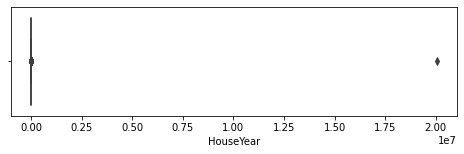


Количество пропущенных элементов 0
median - 1977.0
mean - 3990.17
mode - 1977

1910          1
1912          2
1914          1
1916          1
1917          3
           ... 
2018        175
2019         79
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

Количество уникальных элементов 97


In [70]:
analize(train_df, 'HouseYear')

In [71]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [72]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

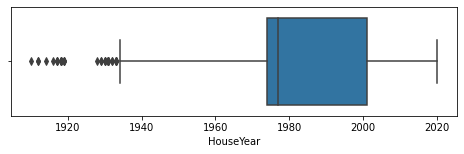


Количество пропущенных элементов 0
median - 1977.0
mean - 1984.87
mode - 1977

1910      1
1912      2
1914      1
1916      1
1917      3
       ... 
2016    305
2017    308
2018    175
2019     79
2020     21
Name: HouseYear, Length: 95, dtype: int64

Количество уникальных элементов 95


In [73]:
analize(train_df, 'HouseYear')

## Ecology_1

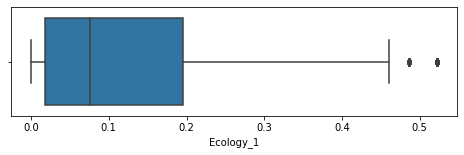


Количество пропущенных элементов 0
median - 0.08
mean - 0.12
mode - 0.01

0.000000e+00    537
1.800000e-09     10
6.998930e-05     83
7.815280e-05    245
1.696760e-04     70
               ... 
4.378852e-01    137
4.581745e-01     67
4.605564e-01     31
4.862456e-01     22
5.218671e-01     39
Name: Ecology_1, Length: 129, dtype: int64

Количество уникальных элементов 129


In [74]:
analize(train_df, 'Ecology_1')

## Social_1

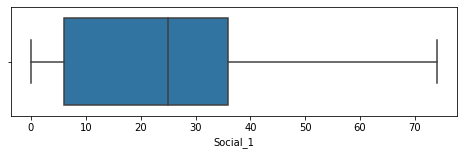


Количество пропущенных элементов 0
median - 25.0
mean - 24.69
mode - 2

0     201
1     654
2     688
3       9
4     141
5     528
6     377
7      15
8      62
9     213
10     24
11    138
12     18
13     22
14     46
15     51
16    123
17     96
18     92
19    118
20     50
21    207
22    367
23    434
24    205
25    557
26    127
27    151
28    144
29     70
30    465
31    243
32     87
33    252
34    311
35    200
36    209
37    205
38     64
39    159
41     83
42    129
43    238
46    245
47    177
49     95
50     79
52    201
53    355
66     99
74    176
Name: Social_1, dtype: int64

Количество уникальных элементов 51


In [75]:
analize(train_df, 'Social_1')

## Social_2

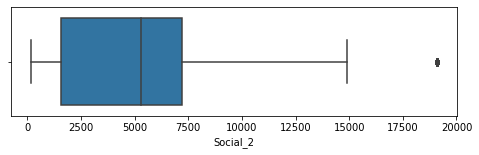


Количество пропущенных элементов 0
median - 5285.0
mean - 5352.16
mode - 264

168      190
186       11
264      587
290       11
388       56
        ... 
11395     95
12238     79
13670    204
14892    151
19083    176
Name: Social_2, Length: 142, dtype: int64

Количество уникальных элементов 142


In [76]:
analize(train_df, 'Social_2')

## Social_3

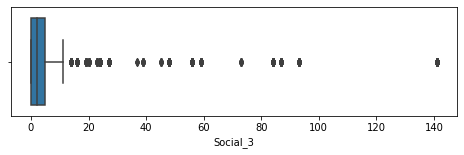


Количество пропущенных элементов 0
median - 2.0
mean - 8.04
mode - 0

0      2997
1      1861
2       635
3      1136
4       835
5       391
6       423
7       184
8       170
9       192
10      142
11      172
14       97
16      101
19       22
20       19
23       18
24       37
27       59
37        3
39       15
45        9
48       58
56       49
59       25
73       10
84       43
87       27
93       25
141     245
Name: Social_3, dtype: int64

Количество уникальных элементов 30


In [77]:
analize(train_df, 'Social_3')

## Healthcare_1

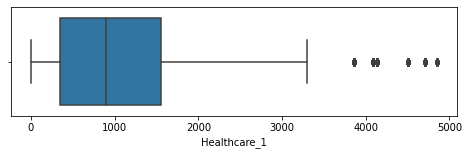


Количество пропущенных элементов 4798
median - nan
mean - 1142.9
mode - 540.0

0.0         1
30.0      348
32.0       12
35.0        2
46.0       49
         ... 
4087.0     45
4129.0     37
4508.0     46
4702.0     27
4849.0     15
Name: Healthcare_1, Length: 79, dtype: int64

Количество уникальных элементов 79


In [78]:
analize(train_df, 'Healthcare_1')

In [79]:
districts_healthcare = train_df.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()

In [80]:
train_df.loc[train_df['Healthcare_1'].isna(), 
             'Healthcare_1'] = train_df['DistrictId'].map(districts_healthcare)


In [81]:
q_max = np.quantile(train_df['Healthcare_1'], q=0.95)

In [82]:
q_max

nan

In [83]:
train_df['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)

In [84]:
train_df['Healthcare_1'].fillna(train_df.Healthcare_1.median(), inplace=True)

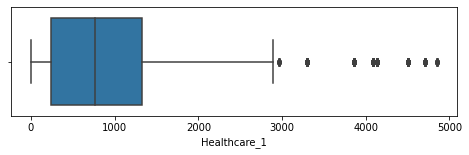


Количество пропущенных элементов 0
median - 770.0
mean - 996.13
mode - 770.0

0.0       565
30.0      487
32.0       12
35.0        2
46.0       49
         ... 
4087.0     45
4129.0     45
4508.0     46
4702.0     27
4849.0     15
Name: Healthcare_1, Length: 110, dtype: int64

Количество уникальных элементов 110


In [85]:
analize(train_df, 'Healthcare_1')

## Healthcare_2

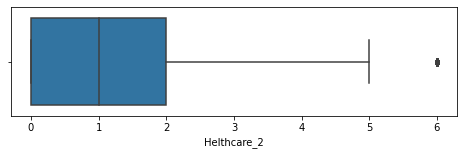


Количество пропущенных элементов 0
median - 1.0
mean - 1.32
mode - 0

0    4214
1    2183
2    1158
3    1670
4     288
5     388
6      99
Name: Helthcare_2, dtype: int64

Количество уникальных элементов 7


In [86]:
analize(train_df, 'Helthcare_2')

## Shops_1

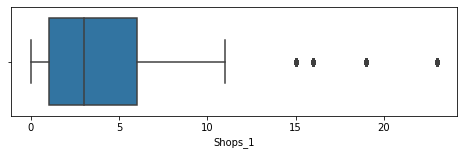


Количество пропущенных элементов 0
median - 3.0
mean - 4.23
mode - 0

0     2316
1     1325
2      964
3      711
4      841
5     1324
6      487
7      294
8      253
9      316
10     215
11     401
15     176
16      83
19      49
23     245
Name: Shops_1, dtype: int64

Количество уникальных элементов 16


In [87]:
analize(train_df, 'Shops_1')

# DataPreprocessing

In [88]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.districts_healthcare = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        
        X = X.copy()
        
        # Расчет медиан
        self.medians = X.median()
        
        # Расчет средней площади для комнаты
        self.mean_square_rooms = X[(X['Square'] < 150)&(X['Square'] >= 10)].\
groupby(['Rooms'], as_index=False).agg({'Square':'median'}).rename(columns={'Square':'MeanSquare'})

        # Вычислите среднее значение Helthcare_1 в каждом районе
        self.districts_healthcare =X.groupby(['DistrictId'])['Healthcare_1'].agg('mean').to_dict()
    
    def transform(self, X):
        """Трансформация данных"""
        
        X = X.copy()
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X['Square_outlires'] = 0        
        X = X.merge(self.mean_square_rooms, on=['Rooms'], how='left', )
        
        conditions = ((X['Square'] > 100) & (X['Rooms'] <= 2))
        X.loc[conditions, 'Square_outlires'] = 1        
        X.loc[conditions, 'Square'] = X[X.Square_outlires == 1].MeanSquare
        
        X.loc[X[X['Square'] < 10].index, 'Square'] = \
        X.loc[X[X['Square'] < 10].index, 'MeanSquare']
        X.loc[X[X['Square'] >= 150].index, 'Square'] = \
        X.loc[X[X['Square'] >= 150].index, 'MeanSquare']
        
        X.loc[X[X['Square'] < 10].index, 'Square_outlires'] = 1
        X.loc[X[X['Square'] >= 150].index, 'Square_outlires'] = 1
        
        X.drop('MeanSquare', axis=1, inplace=True)
                
        # KitchenSquare
        X['KitchenSquare_outlires'] = 0
        X.loc[conditions, 'KitchenSquare_outlires'] = 1
        condition = ((X['KitchenSquare'].isna()) \
                     | (X['KitchenSquare'] > (X['Square'] * 0.5)) \
                     | (X['KitchenSquare'] < 3))
        
        X.loc[condition, 'KitchenSquare'] = 0.15 * X.loc[condition, 'Square']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Заполним средними значениями по районам, если отсутствует то заполним средним по диапазону.  
        X.loc[X['Healthcare_1'].isna(), 'Healthcare_1'] =X['DistrictId'].map(self.districts_healthcare)
        X['Healthcare_1'].fillna(self.medians.Healthcare_1, inplace=True)       
        # Ограничим сверху квантилем 
        q_max = np.quantile(X['Healthcare_1'], q=0.95)
        X['Healthcare_1'].clip(upper=q_max, axis=0, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        X['LifeSquare_outlires'] = 0
        condition = ((X['LifeSquare'] < 10) | (X['LifeSquare'] >= 150))
        X.loc[conditions, 'LifeSquare_outlires'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                        - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = X[X['KitchenSquare'] > X['LifeSquare']].index
        X.loc[conditions, 'LifeSquare_outlires'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                                - X.loc[condition, 'KitchenSquare']
        
        condition = X[X['LifeSquare'] > X['Square']].index
        X.loc[conditions, 'LifeSquare_outlires'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                                - X.loc[condition, 'KitchenSquare'] - 3
        
        condition = X[X['Square'] < X['KitchenSquare'] +  X['LifeSquare']].index
        X.loc[conditions, 'LifeSquare_outlires'] = 1
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                                - X.loc[condition, 'KitchenSquare'] - 3
        x = X.LifeSquare/X.Rooms
        condition = X[x < 10].index
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] \
                                                - X.loc[condition, 'KitchenSquare'] - 3
        X.fillna(self.medians, inplace=True)
        
        return X

# Построение новых признаков

## Dummies

In [89]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

## DistrictSize, IsDistrictLarge

In [90]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [91]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,Square_outlires,KitchenSquare_outlires,LifeSquare_nan,LifeSquare_outlires,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.000000,4,10.0,2014,0.075424,...,0,1,305018.871089,0,0,0,1,0,0,851
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,0,0,0,652
3,2352,1,1.0,40.409907,31.348421,6.061486,10,22.0,1977,0.007122,...,1,1,168106.007630,0,0,0,1,0,0,652
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,0,0,0,89


In [92]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [93]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)


## MedPriceByDistrict

In [94]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [95]:
med_price_by_district.shape

(667, 3)

In [96]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,Square_outlires,KitchenSquare_outlires,LifeSquare_nan,LifeSquare_outlires,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.000000,4,10.0,2014,0.075424,...,305018.871089,0,0,0,1,0,0,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,177734.553407,0,0,0,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,282078.720850,0,0,0,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,31.348421,6.061486,10,22.0,1977,0.007122,...,168106.007630,0,0,0,1,0,0,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,343995.102962,0,0,0,0,0,0,89,0,201584.441255


## MedPriceByFloorYear

In [97]:
def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def floor_to_cat_pandas(X):
    bins = [0, 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X


def year_to_cat_pandas(X):
    bins = [0, 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [98]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins, labels=False)

0       1
1       2
2       0
3       3
4       4
       ..
9995    0
9996    3
9997    0
9998    0
9999    2
Name: Floor, Length: 10000, dtype: int64

In [99]:
bins = [0, 3, 5, 9, 15, train_df['Floor'].max()]
pd.cut(train_df['Floor'], bins=bins)

0         (3, 5]
1         (5, 9]
2         (0, 3]
3        (9, 15]
4       (15, 42]
          ...   
9995      (0, 3]
9996     (9, 15]
9997      (0, 3]
9998      (0, 3]
9999      (5, 9]
Name: Floor, Length: 10000, dtype: category
Categories (5, interval[int64]): [(0, 3] < (3, 5] < (5, 9] < (9, 15] < (15, 42]]

In [100]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Square_outlires,KitchenSquare_outlires,LifeSquare_nan,LifeSquare_outlires,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.000000,4,10.0,2014,0.075424,...,0,0,1,0,0,851,1,213530.788443,6,2
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,0,0,0,0,0,78,0,146032.829834,3,3
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,0,0,0,0,0,652,1,244005.272380,4,1
3,2352,1,1.0,40.409907,31.348421,6.061486,10,22.0,1977,0.007122,...,0,0,1,0,0,652,1,146735.671740,3,4
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,0,0,0,0,0,89,0,201584.441255,3,5


In [101]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head()

,year_cat,floor_cat,MedPriceByFloorYear
0,1,1,368718.236013
1,1,2,321506.277104
2,1,3,421756.290145
3,1,4,274992.472366
4,2,1,467230.539057


In [102]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,KitchenSquare_outlires,LifeSquare_nan,LifeSquare_outlires,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.000000,4,10.0,2014,0.075424,...,0,1,0,0,851,1,213530.788443,6,2,163969.984699
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,0,0,0,0,78,0,146032.829834,3,3,192538.872015
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,0,0,0,0,652,1,244005.272380,4,1,203932.254827
3,2352,1,1.0,40.409907,31.348421,6.061486,10,22.0,1977,0.007122,...,0,1,0,0,652,1,146735.671740,3,4,184201.773729
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,0,0,0,0,89,0,201584.441255,3,5,171621.224416


# FeatureGenetator

In [103]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_price_by_district = df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                                            .rename(columns={'Price':'MedPriceByDistrict'})
            
            self.med_price_by_district_median = self.med_price_by_district['MedPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        
        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
            X['MedPriceByDistrict'].fillna(self.med_price_by_district_median, inplace=True)
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X['MedPriceByFloorYear'].fillna(self.med_price_by_floor_year_median, inplace=True)
        
        return X
    
    def floor_to_cat(self, X):
        # min этаж
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

# Отбор признаков

In [104]:
train_df = pd.read_csv('train.csv.zip')
test_df = pd.read_csv('test.csv')

In [105]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [106]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [107]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [108]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 
                 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1',
                 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'Square_outlires', 'KitchenSquare_outlires',
                     'HouseFloor_outlier', 
                     'HouseYear_outlier', 'LifeSquare_nan', 'LifeSquare_outlires',
                     'DistrictSize',
                     'new_district', 'IsDistrictLarge',  'year_cat', 'floor_cat',
                     #'MedPriceByDistrict', 
                     'MedPriceByFloorYear']

target_name = 'Price'

# Разбиение на train и test

In [109]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [110]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.33,
                                                      shuffle=True, 
                                                      random_state=21)

In [111]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [112]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 33), (3300, 33), (5000, 33))

In [113]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [114]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), \
test_df.isna().sum().sum()

(0, 0, 0)

In [115]:
X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

# Построение модели

## Обучение

In [116]:
from sklearn.ensemble import GradientBoostingRegressor

rf_model = GradientBoostingRegressor(random_state=1, 
                                     criterion='mse', 
                                     n_estimators=1000,).fit(X_train, y_train)

Train R2:	0.906
Test R2:	0.749


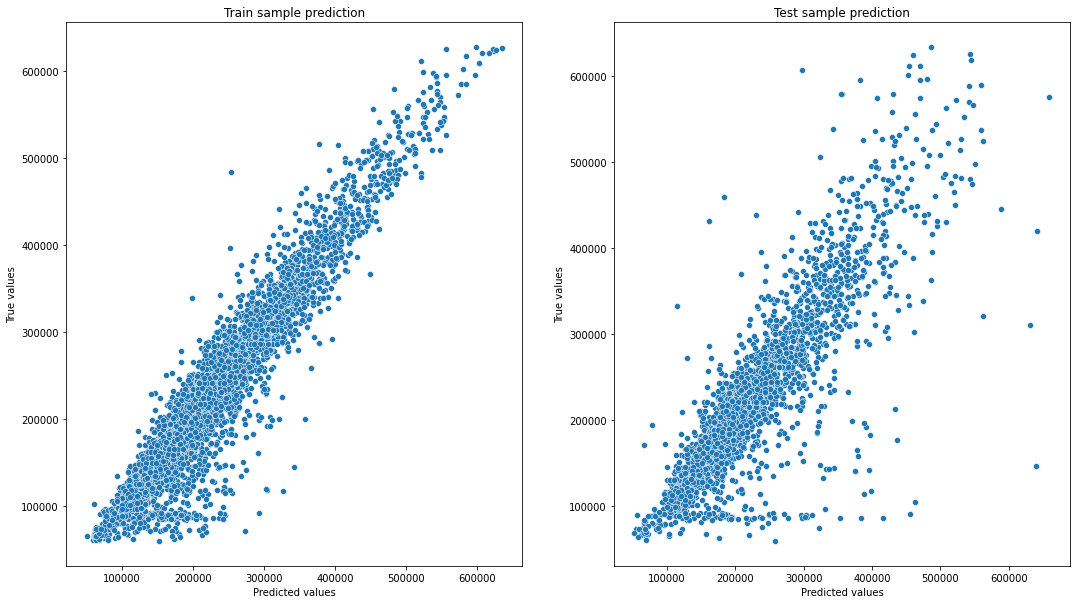

In [117]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

## Кросс-валидация

In [118]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, 
                                                                              shuffle=True, 
                                                                              random_state=1))
cv_score

array([0.7058398 , 0.7186724 , 0.71361492])

In [119]:
cv_score.mean()

0.7127090409715127

## Важность признаков

In [120]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)


,feature_name,importance
1,Square,0.440177
23,DistrictSize,0.226741
12,Social_3,0.054852
11,Social_2,0.039674
2,LifeSquare,0.031840
7,Ecology_1,0.030801
10,Social_1,0.028588
0,Rooms,0.026678
28,MedPriceByFloorYear,0.025503
6,HouseYear,0.023871


# Прогнозирование на тестовом датасете 

In [121]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [122]:
predictions = rf_model.predict(test_df)
predictions

array([174841.52871853, 129085.71597418, 144245.60904841, ...,
       143732.5088143 , 195327.16572205, 253063.72064979])

In [123]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,174841.528719
1,5925,129085.715974
2,960,144245.609048
3,3848,106934.086793
4,746,198776.333928


In [124]:
submit.to_csv('rf_submit.csv', index=False)